
# Distance Metrics

**Author:**


Asfand Yar Khan
Matriculation Number: 23171007
IDM ID: xa52jygo

In [43]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

from src.finance_ml.data_preparation.data_preparation import DataLoader
from finance_ml.distance_metrics.distance_metrics import DistanceMetrics
from src.finance_ml.denoising.denoising import Denoising


## Reading the Data File

In [44]:
from finance_ml.data_preparation import Asset

dataloader = DataLoader(time_index_col= 'DATE',keep_cols = ['VOLUME','OPEN', 'CLOSE', 'LOW', 'TRANSACTIONS'])

data = dataloader.load_dataset({'IGIB':'../data/fixed_income/IGIB_2020-04-07_2022-04-06.parquet'})
asset1 = Asset(ticker="IGIB", data= data, index_name=dataloader.time_index_col)
data = dataloader.load_dataset({'USIG':'../data/fixed_income/USIG_2020-04-07_2022-04-06.parquet'})
asset2 = Asset(ticker="USIG", data = data, index_name=dataloader.time_index_col)
data = dataloader.load_dataset({'VCIT':'../data/fixed_income/VCIT_2020-04-07_2022-04-06.parquet'})
asset3 = Asset(ticker="VCIT", data = data, index_name=dataloader.time_index_col)

igib = asset1.data
usig = asset2.data
vcit = asset3.data

igib['DATE_TRUNC'] = igib.index.floor('D')
usig['DATE_TRUNC'] = usig.index.floor('D')
vcit['DATE_TRUNC'] = vcit.index.floor('D')

igib = igib.groupby(['DATE_TRUNC']).agg({'IGIB_TRANSACTIONS':'sum'}).reset_index()
usig = usig.groupby(['DATE_TRUNC']).agg({'USIG_TRANSACTIONS':'sum'}).reset_index()
vcit = vcit.groupby(['DATE_TRUNC']).agg({'VCIT_TRANSACTIONS':'sum'}).reset_index()

igib = igib[igib['DATE_TRUNC']>dt.datetime(2021,7,1)]
usig = usig[usig['DATE_TRUNC']>dt.datetime(2021,7,1)]
vcit = vcit[vcit['DATE_TRUNC']>dt.datetime(2021,7,1)]

igib = igib.set_index('DATE_TRUNC')
usig = usig.set_index('DATE_TRUNC')
vcit = vcit.set_index('DATE_TRUNC')

In [45]:
# Normalizing Data
usig = np.log(usig/usig.shift(1)).dropna()
igib = np.log(igib/igib.shift(1)).dropna()
vcit = np.log(vcit/vcit.shift(1)).dropna()
matrix = pd.concat([igib, usig, vcit], axis = 1)
matrix.columns = ['IGIB','USIG','VCIT']

In [58]:
# loading assets into to an unique df
df1 = pd.DataFrame(igib)
df2 = pd.DataFrame(usig)
df3 = pd.DataFrame(vcit)

# Merge columns from different variables based on a common column (ID in this case)
merged_df = pd.merge(pd.merge(df1, df2, on='DATE_TRUNC'), df3, on='DATE_TRUNC')
merged_df[:10].to_clipboard()

In [50]:
# Create an object to calculate the distance metrics
dist_metrics = DistanceMetrics(merged_df, merged_df.columns)

            IGIB_TRANSACTIONS  USIG_TRANSACTIONS  VCIT_TRANSACTIONS
DATE_TRUNC                                                         
2021-07-06           0.168530          -0.158587           0.452623
2021-07-07           0.063331           1.495123          -0.222141
2021-07-08          -0.076724          -0.829083           0.121707
2021-07-09          -0.554286          -0.259553          -0.376490
2021-07-12           0.003714          -0.118258           0.329779
...                       ...                ...                ...
2022-03-31          -0.055729          -0.283188           0.148684
2022-04-01          -0.094882           0.496827          -0.140254
2022-04-04           0.617316          -0.399938           0.765173
2022-04-05          -0.163566           1.041828          -0.745580
2022-04-06           0.838440          -0.038611           1.344300

[192 rows x 3 columns]


## Finding the Pearson Correlation

 The Pearson correlation coefficient is a measure of the linear relationship between two variables. It ranges from -1 to 1, where:

> 1 indicates a perfect positive linear relationship,
> 0 indicates no linear relationship,
> -1 indicates a perfect negative linear relationship.


In [51]:
dist_metrics.pearson_cor()

(                   IGIB_TRANSACTIONS  USIG_TRANSACTIONS  VCIT_TRANSACTIONS
 IGIB_TRANSACTIONS           1.000000           0.050160           0.170434
 USIG_TRANSACTIONS           0.050160           1.000000           0.029892
 VCIT_TRANSACTIONS           0.170434           0.029892           1.000000,
                    IGIB_TRANSACTIONS  USIG_TRANSACTIONS  VCIT_TRANSACTIONS
 IGIB_TRANSACTIONS           1.000000           0.050160           0.170434
 USIG_TRANSACTIONS           0.050160           1.000000           0.029892
 VCIT_TRANSACTIONS           0.170434           0.029892           1.000000)

## Finding the Euclidean Distance

Euclidean distance is a measure of the straight-line distance between two points in Euclidean space. In two-dimensional space, the Euclidean distance between two points (x₁, y₁) and (x₂, y₂) is given by the formula:

\[ d = \sqrt{(x₂ - x₁)^2 + (y₂ - y₁)^2} \]

In three-dimensional space, the formula extends to:

\[ d = \sqrt{(x₂ - x₁)^2 + (y₂ - y₁)^2 + (z₂ - z₁)^2} \]

And in n-dimensional space, the formula is generalized as follows:

\[ d = \sqrt{\sum_{i=1}^{n}(x_{2i} - x_{1i})^2} \]

Euclidean distance is a fundamental concept in geometry and is often used in various fields, including mathematics, physics, computer science, and machine learning. It provides a measure of "straight-line" or "as-the-crow-flies" distance between two points in space.


In [52]:
dist_metrics.euclidean_dist()

,IGIB_TRANSACTIONS,USIG_TRANSACTIONS,VCIT_TRANSACTIONS
IGIB_TRANSACTIONS,0.000000,11.797393,13.254990
USIG_TRANSACTIONS,11.797393,0.000000,12.143298
VCIT_TRANSACTIONS,13.254990,12.143298,0.000000


We will perform the denoising of a covariance matrix using Principal Component Analysis (PCA) and a denoising algorithm. The key steps are as follows:

1. Initialization of parameters such as `alpha`, `nCols`, `nFact`, and `q`.
2. Generation of a random covariance matrix using the function `getRndCov`.
3. Creation of a `Denoising` object with a specified parameter `q`.
4. Combination of the original covariance matrix and the denoised version using the denoising algorithm and a randomly generated covariance matrix.
5. Conversion of the covariance matrix to a correlation matrix.
6. Calculation of eigenvalues and eigenvectors using PCA.
7. Identification of the maximum eigenvalue and estimation of the number of factors.
8. Generation of a denoised correlation matrix and recalculation of eigenvalues and eigenvectors for the denoised matrix.
9. Extraction of denoised eigenvalues and original eigenvalues.


In [55]:
alpha, nCols, nFact, q = 0.995, 3, 100, 10.0

def getRndCov(nCols, nFacts):
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size=nCols))
    return cov

denoise_processor = Denoising(q=q)

cov = alpha * matrix.cov() + (1-alpha) * getRndCov(nCols, nFact)
corr0 = denoise_processor.cov_to_corr(cov)
eVal0, eVec0 = denoise_processor.calc_PCA(corr0)

eMax0, var0, q = denoise_processor.find_max_eval(np.diag(eVal0))
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

corr1 = denoise_processor.denoised_corr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = denoise_processor.calc_PCA(corr1)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

denoised_eigenvalue

/Users/asfand/Desktop/ML in Finance/ML-in-Finance/src/finance_ml/denoising/denoising.py:498: RuntimeWarning: invalid value encountered in scalar divide
  eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)


array([1.06332981, 0.99616711, 0.94050308])

Text(0.5, 1.0, 'Denoising with Constant residual eigenvalue method')

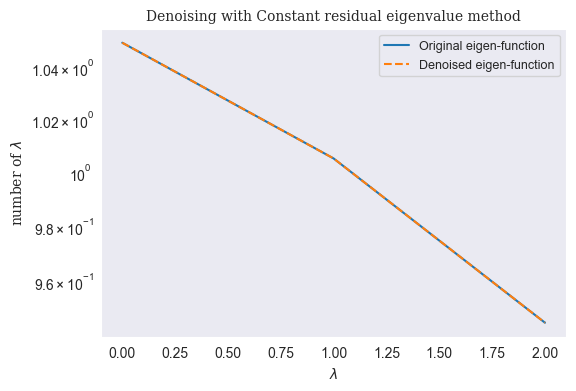

In [11]:
plt.figure(figsize = (6,4))
plt.grid(False)
plt.plot(eigenvalue_prior, label = 'Original eigen-function')
plt.plot(denoised_eigenvalue, label = 'Denoised eigen-function', ls = '--')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontfamily='Serif')
plt.ylabel(r'number of $\lambda$', fontfamily='Serif')
plt.legend(loc='upper right', fontsize=9)
plt.title('Denoising with Constant residual eigenvalue method', fontsize=10, fontfamily='Serif')

In [12]:
matrix_denoised = pd.DataFrame(eVec1, columns = matrix.columns, index = matrix.columns)
matrix_denoised

,IGIB,USIG,VCIT
IGIB,0.708324,0.199854,-0.677005
USIG,-0.010506,-0.955992,-0.293203
VCIT,0.705809,-0.214795,0.675053


## Correlation Based Metric

\[ \text{result} = \sqrt{2 \cdot T \cdot (1 - |\text{corr}|)} \]


In [13]:
dist_metrics.corr_based_metric(matrix_denoised)

,IGIB,USIG,VCIT
IGIB,1.322897,2.191091,1.392110
USIG,2.436589,0.513854,2.059315
VCIT,1.328587,2.170536,1.396311


Text(0.5, 1.0, 'A Correlation based metric')

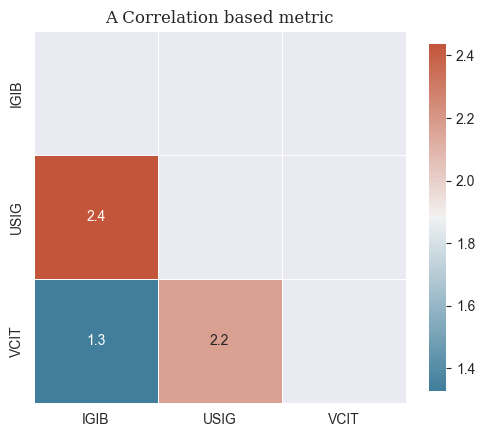

In [14]:
import seaborn as sns
mask = np.triu(np.ones_like(matrix.cov(), dtype = bool))
f, ax = plt.subplots(figsize = (6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(dist_metrics.corr_based_metric(matrix_denoised), mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('A Correlation based metric', fontsize = 12, fontfamily = 'Serif')

In [15]:
bins = dist_metrics.num_bins(len(igib))

In [16]:
bins

9

In [17]:
np.asarray(igib)[:,0]

array([ 1.68530013e-01,  6.33311898e-02, -7.67235180e-02, -5.54286378e-01,
        3.71375945e-03,  5.06711097e-01, -1.40303233e-01, -2.75175771e-01,
        3.64194751e-01,  2.16539514e-01,  6.01876544e-02, -5.57561133e-01,
       -2.15628755e-01,  4.73229259e-01,  1.19693727e-01,  1.98339274e-01,
       -3.22484872e-01,  1.56786390e-02, -9.98041572e-02,  1.73519875e-01,
       -2.53916538e-01,  2.98471780e-01, -3.90937008e-01,  2.10370008e-01,
        1.17826319e-01, -6.60068403e-03, -3.09885628e-01, -2.97151011e-01,
       -5.36304709e-01,  8.54845653e-01, -1.05360516e-01,  1.59452216e-01,
        3.09581951e-01, -7.16038958e-01,  2.08280079e-01,  2.22767440e-01,
       -3.27740052e-01,  4.80511709e-02,  5.99002088e-01, -4.74324102e-01,
        6.41246008e-01, -3.95272681e-01, -4.60432309e-01, -2.24310640e-01,
        1.17739784e-01,  1.78331201e-02,  5.16671198e-02, -3.96467618e-01,
        7.07439944e-01,  1.89035973e-03,  1.04145387e+00, -1.32945076e+00,
        8.65130002e-01, -

### Marginal Entropy:

Marginal entropy represents the uncertainty or average amount of information contained in a single random variable without considering other variables. It is a measure of the disorder or unpredictability of a single variable.

**Formula:**
\[ H(X) = -\sum_{i} P(x_i) \cdot \log_2(P(x_i)) \]

Here, \(H(X)\) is the marginal entropy of the random variable \(X\), and \(P(x_i)\) is the probability of the i-th outcome.

### Joint Entropy:

Joint entropy measures the uncertainty or average amount of information contained in a set of random variables considered together. It reflects the combined disorder or unpredictability of multiple variables.

**Formula:**
\[ H(X, Y) = -\sum_{i,j} P(x_i, y_j) \cdot \log_2(P(x_i, y_j)) \]

Here, \(H(X, Y)\) is the joint entropy of random variables \(X\) and \(Y\), and \(P(x_i, y_j)\) is the joint probability of the i-th outcome of \(X\) and the j-th outcome of \(Y\).

These formulas use the logarithm base 2 to measure entropy in bits. The negative sign is used to ensure the result is non-negative.


In [18]:
cXY = np.histogram2d(np.asarray(igib)[:,0], np.asarray(vcit)[:,0], bins)[0]
hX = ss.entropy(np.histogram(igib, bins)[0]) #marginal
hY = ss.entropy(np.histogram(vcit, bins)[0]) #marginal
iXY = mutual_info_score(None, None, contingency=cXY)
iXYn = iXY/min(hX, hY) #normalized mutual information
hXY = hX+hY - iXY #joint
hX_Y = hXY-hY #conditional
hY_X = hXY-hX #contitional

print('**'*8+'\n')
print('hX marginal entropy: {}'.format(hX))
print('hY marginal entropy: {}'.format(hY))
print('iXY mutual info score: {}'.format(iXY))
print('iXYn normalized mutual information: {}'.format(iXYn))
print('hX_Y cross entropy between x and y : {}'.format(hX_Y))
print('hY_X cross entropy between y and x : {}'.format(hY_X))

****************

hX marginal entropy: 0.2775249948505651
hY marginal entropy: 0.09722607641528785
iXY mutual info score: 0.01811831415747506
iXYn normalized mutual information: 0.18635241516982715
hX_Y cross entropy between x and y : 0.25940668069309003
hY_X cross entropy between y and x : 0.0791077622578128


In [19]:
nmi = dist_metrics.mutual_info(np.asarray(igib)[:,0],np.asarray(vcit)[:,0], bins,True)
corr = np.corrcoef(np.asarray(igib)[:,0],np.asarray(vcit)[:,0])[0,1]

print('NMI: ', nmi)
print('Correlation: ', corr)

NMI:  0.18635241516982715
Correlation:  0.06869233466905661


In [20]:
def show_results(x, y):
    result_dict = {
        "H[X]": dist_metrics.marginal(x, bins),
        "H[Y]": dist_metrics.marginal(y, bins),
        "H[X,Y]": dist_metrics.joint(x, y, bins=bins),
        "H[X|Y]": dist_metrics.conditional(x, y, bins=bins),
        "I[X,Y]": dist_metrics.mutual_info(x, y, bins=bins),
        "VI[X,Y]": dist_metrics.variation_info(x, y, bins=bins),
        "VI_N[X,Y]": dist_metrics.variation_info(x, y, bins=bins, norm=True)
    }

    # Extract keys and values
    categories = list(result_dict.keys())
    values = list(result_dict.values())

    # Create a bar plot
    plt.bar(categories, values, color='red')

    # Customize the plot
    plt.title('Information Measures')
    plt.xlabel('Categories')
    plt.ylabel('Values')

    # Display the plot
    plt.show()

    fig, axs = plt.subplots(1, figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    # marker symbol
    nmi = dist_metrics.mutual_info(x, y, norm=True)
    corr = np.corrcoef(x,y)[0,1]
    axs.scatter(x, y)
    axs.text(0.1, 0.9, f"nmi={nmi}; \n corr={corr}",
         horizontalalignment='center',
         verticalalignment='center',
         transform = axs.transAxes)

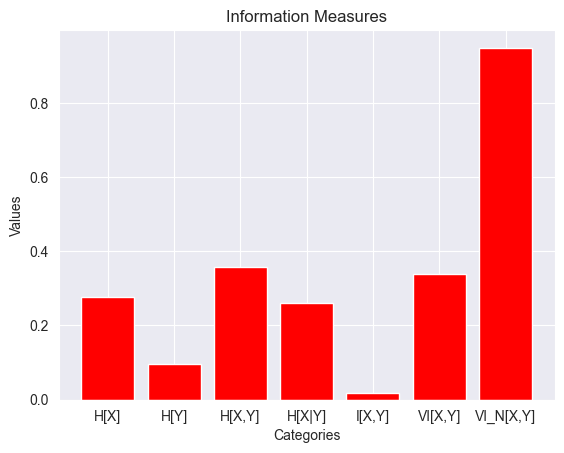

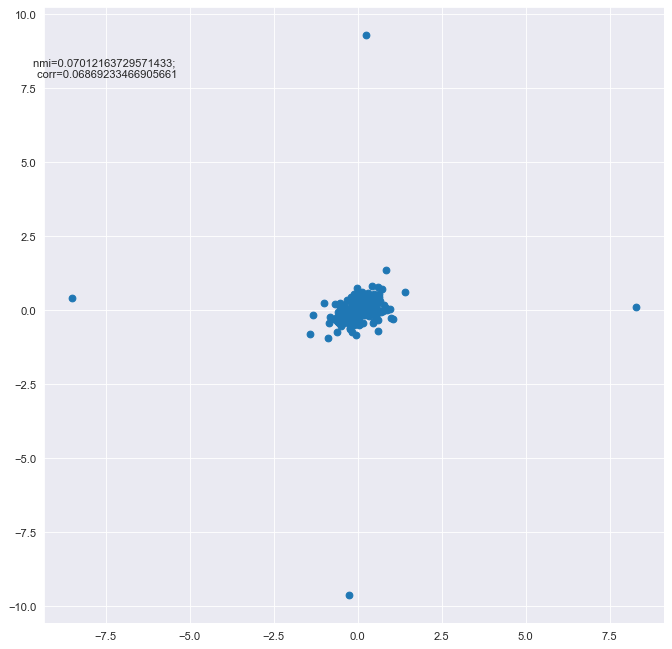

In [21]:
x = np.asarray(igib)[:,0]
y = np.asarray(vcit)[:,0]

show_results(x, y)

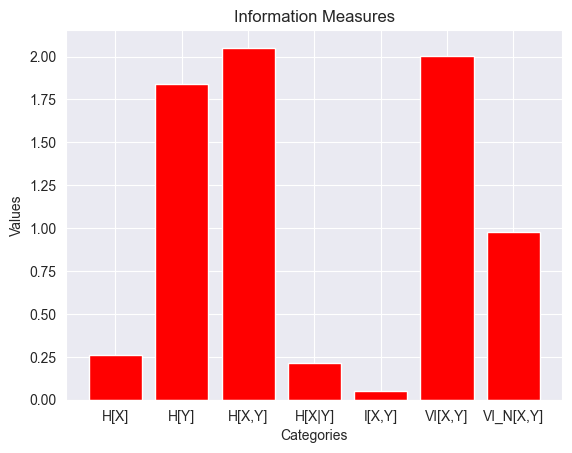

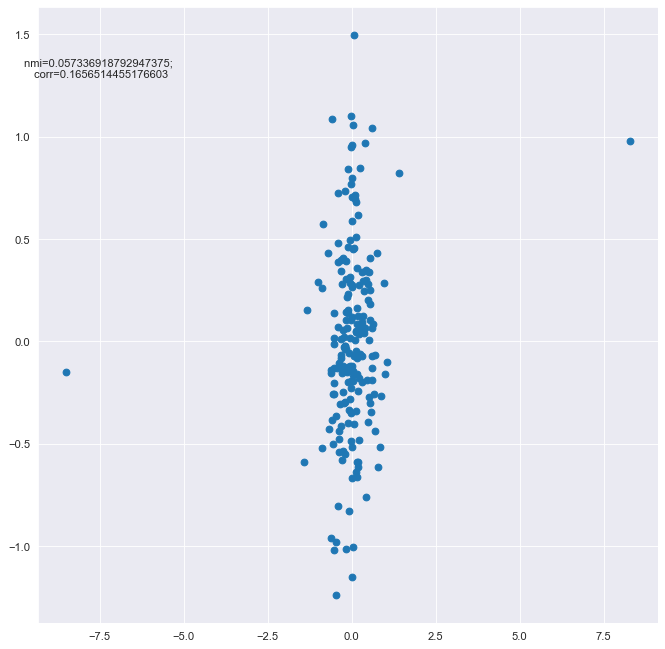

In [22]:
x = np.asarray(igib)[:192,0]
y = np.asarray(usig)[:192,0]

show_results(x, y)


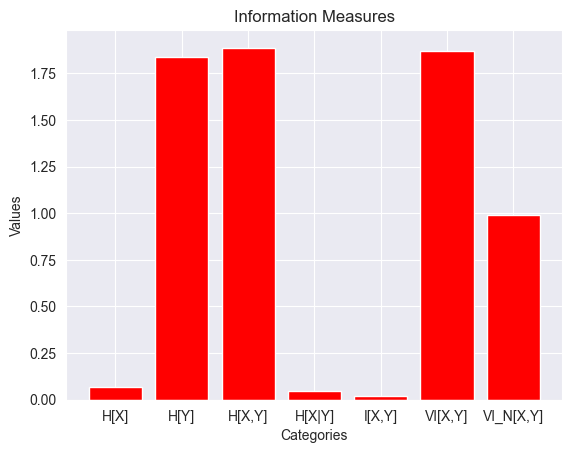

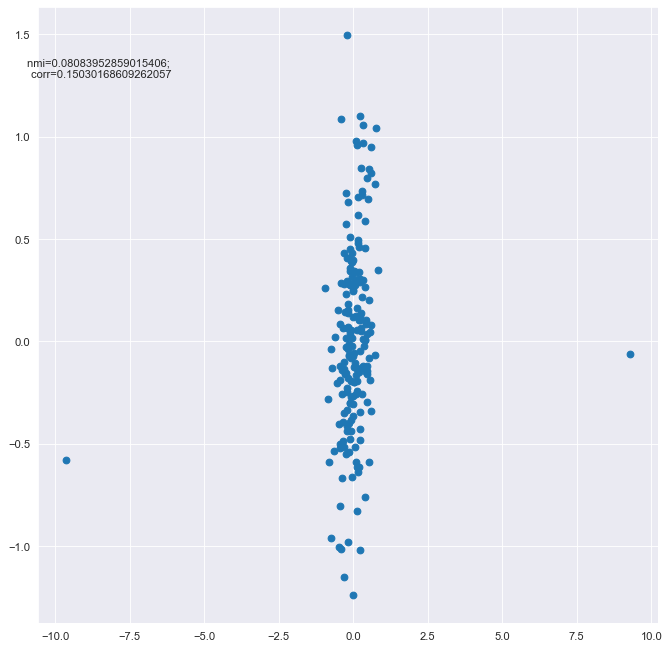

In [23]:
x = np.asarray(vcit)[:192,0]
y = np.asarray(usig)[:192,0]

show_results(x, y)

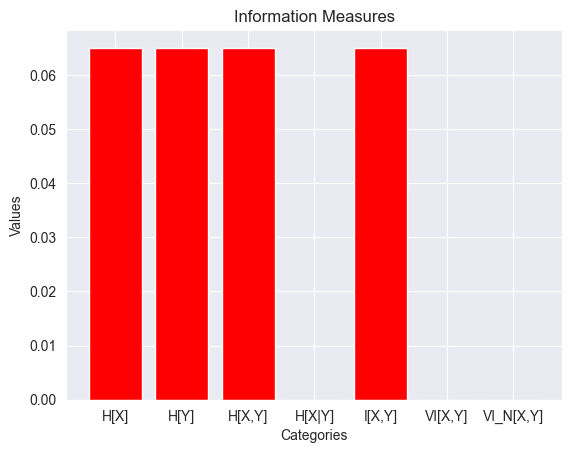

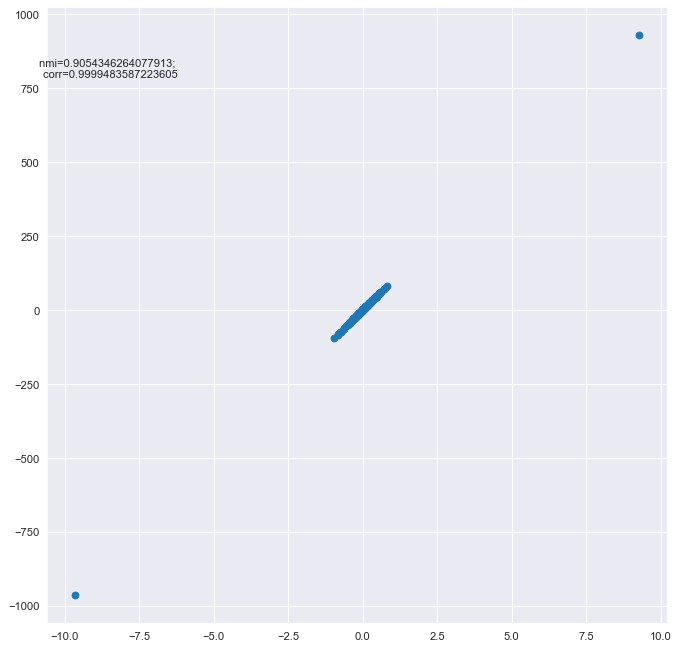

In [28]:
x = np.asarray(vcit)[:192,0]
e = np.random.normal(size=192)
y = 100*x+e

show_results(x, y)

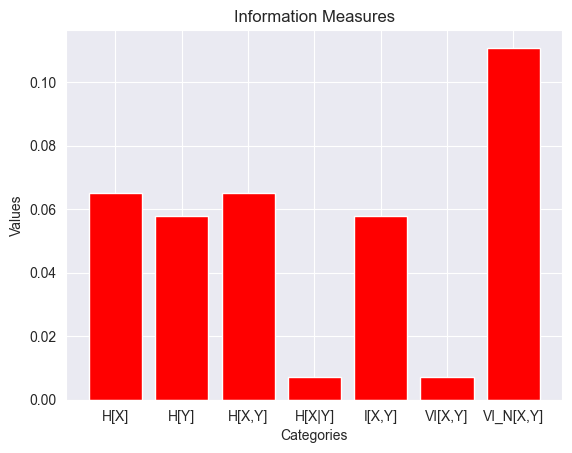

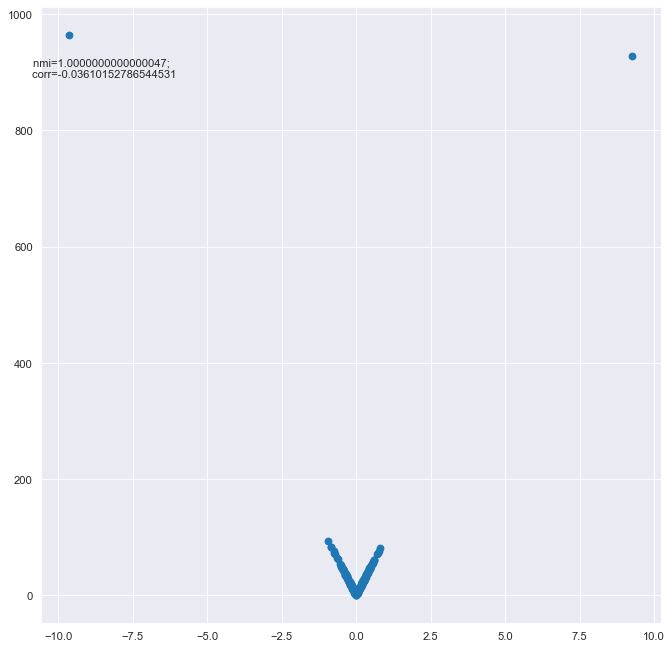

In [27]:
x = np.asarray(vcit)[:192,0]
e = np.random.normal(size=192)
y = 100*abs(x)+e

show_results(x, y)